<a href="https://colab.research.google.com/github/qiuyuezhibo/XAISPAM/blob/main/XAI_for_CNN_image_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-rays Project
image classification


In [ ]:
import pandas as pd
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
import glob
from pathlib import Path
import cv2

import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Process the images


In [ ]:
import keras
from keras import backend as K
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
#from keras.layers.normalization import BatchNormalization
import tensorflow
tensorflow.compat.v1.disable_eager_execution()
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam,Adamax
#from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [ ]:
#included in our dependencies
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 zoom_range=0.1,
                                 horizontal_flip=False)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)#(rescale=1./255)

In [ ]:
# this is where you specify the path to the main data folder
train_generator=train_datagen.flow_from_directory(
    '/content/drive/My Drive/image_dataset/train/',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/image_dataset/test/',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 4977 images belonging to 2 classes.
Found 1659 images belonging to 2 classes.


# Model
Fine Tuning MobileNet

In [ ]:
K.clear_session()

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              min_delta=0.0001, patience=1, verbose=1)

In [ ]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=1, save_best_only=True, mode='min')

In [ ]:
#from keras.applications.mobilenet_v2 import MobileNetV2
#base_model = MobileNetV2(weights='imagenet',include_top=False)

#imports the mobilenet model and discards the last 1000 neuron layer.
base_model = MobileNet(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=1-0.5)(x)
#x = Dense(512, kernel_regularizer='l2', kernel_initializer='he_normal', activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(rate=1-0.5)(x)
x = Dense(256, kernel_regularizer='l2', kernel_initializer='he_normal', activation='relu')(x)
x = Dropout(rate=1-0.5)(x)
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation

Instructions for updating:
Colocations handled automatically by placer.


17225924/17225924 [==============================] - 1s 0us/step


Insert a batch normalization layer between convolution and activation layers and do note use dropout to conv layers [(source)](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf)

In [ ]:
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
print('the network has {} layers'.format(len(model.layers)))

the network has 91 layers


We freeze the first 65, because we want to maintain the abstract shapes that MobileNet has learned from imagenet dataset

In [ ]:
model.layers[53:] # 65layers: val_loss: 0.3193 - val_acc: 0.8885
#model.layers[34:] #try to train more layers  34

In [ ]:
for layer in model.layers[:53]:
    layer.trainable=False
for layer in model.layers[53:]:
    layer.trainable=True

In [ ]:
#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay = 0.0001, amsgrad=False)
#opt = Adamax(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
from keras.optimizers import SGD
#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                      

In [ ]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=step_size_train,
                              validation_steps=step_size_val,
                              callbacks=[lr_reduce,checkpoint],
                              epochs=5)

Epoch 1/5


<ipython-input-18-c0215d2d65db>:4: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


155/155 [==============================] - ETA: 0s - batch: 77.0000 - size: 31.9032 - loss: 2.1436 - accuracy: 0.9895
Epoch 1: val_loss improved from inf to 1.79903, saving model to weights.hdf5
155/155 [==============================] - 252s 2s/step - batch: 77.0000 - size: 31.9032 - loss: 2.1436 - accuracy: 0.9895 - val_loss: 1.7990 - val_accuracy: 0.8946 - lr: 0.0100
Epoch 2/5
155/155 [==============================] - ETA: 0s - batch: 77.0000 - size: 31.9032 - loss: 1.1609 - accuracy: 0.9911
Epoch 2: val_loss improved from 1.79903 to 1.00193, saving model to weights.hdf5
155/155 [==============================] - 92s 594ms/step - batch: 77.0000 - size: 31.9032 - loss: 1.1609 - accuracy: 0.9911 - val_loss: 1.0019 - val_accuracy: 0.9473 - lr: 0.0100
Epoch 3/5
155/155 [==============================] - ETA: 0s - batch: 77.0000 - size: 31.9032 - loss: 0.6243 - accuracy: 0.9958
Epoch 3: val_loss improved from 1.00193 to 0.74316, saving model to weights.hdf5
155/155 [====================

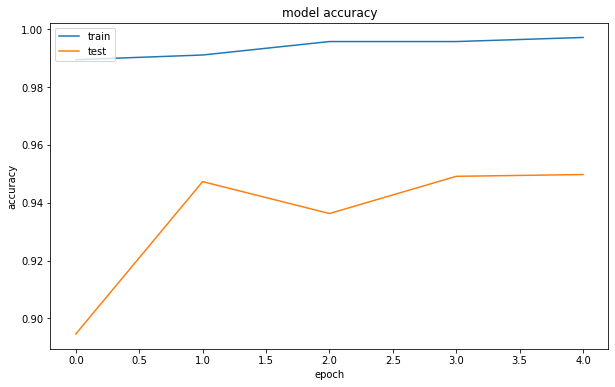

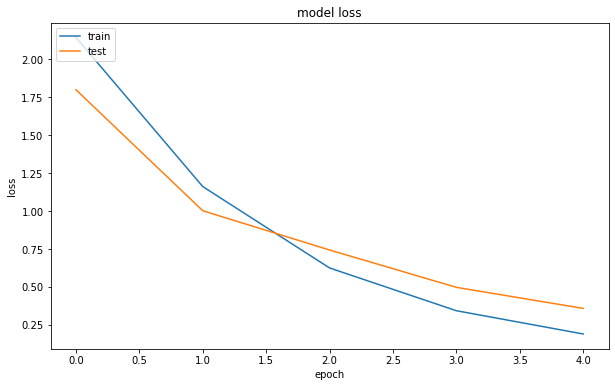

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The network is clearly overfitting after 2nd epoch, thus we saved the weights of the epoch with the lowerst validation error

In [ ]:
model.load_weights('weights.hdf5')

# Confusion Matrix

In [ ]:
def proc_img(img_path):
  "process the image"
  # `img` is a PIL image of size 224x224
  img = image.load_img(img_path, target_size=(224, 224))

  # `x` is a float32 Numpy array of shape (224, 224, 3)
  x_img = image.img_to_array(img)

  # We add a dimension to transform our array into a matrix
  # of size (1, 224, 224, 3)
  x_img = np.expand_dims(x_img, axis=0)

  # Finally we preprocess the batch
  # (this does channel-wise color normalization)
  #x_img = preprocess_input(x_img)
  x_img = preprocess_input(x_img)
  return x_img

In [ ]:
test_path = Path('/content/drive/My Drive/image_dataset/test/')

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_path / 'class1'
pneumonia_cases_dir = test_path / 'class2'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.JPG')
pneumonia_cases = pneumonia_cases_dir.glob('*.JPG')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

# Shuffle the data
test_data = test_data.sample(frac=1.).reset_index(drop=True)

In [ ]:
'''
results=[]
normal_cases_dir = os.listdir(normal_cases_dir)
pneumonia_cases_dir = os.listdir(pneumonia_cases_dir)
for img in normal_cases_dir:
  test_image = image.load_img(img, target_size=(224, 224))
  test_image1 = image.img_to_array(test_image)
  test_image2 = np.expand_dims(test_image1, axis=0)
  test_image2 = preprocess_input(test_image2)
  results.append(model.predict(test_image2))
  if results[-1] >= 0.5:
    results[-1] = 1.0
  else:
    results[-1] = 0.0

for img in pneumonia_cases_dir:
  test_image = image.load_img(img, target_size=(224, 224))
  test_image1 = image.img_to_array(test_image)
  test_image2 = np.expand_dims(test_image1, axis=0)
  test_image2 = preprocess_input(test_image2)
  results.append(model.predict(test_image2))
  if results[-1] >= 0.5:
    results[-1] = 1.0
  else:
    results[-1] = 0.0
'''

'\nresults=[]\nnormal_cases_dir = os.listdir(normal_cases_dir)\npneumonia_cases_dir = os.listdir(pneumonia_cases_dir)\nfor img in normal_cases_dir:\n  test_image = image.load_img(img, target_size=(224, 224))\n  test_image1 = image.img_to_array(test_image)\n  test_image2 = np.expand_dims(test_image1, axis=0)\n  test_image2 = preprocess_input(test_image2)\n  results.append(model.predict(test_image2))\n  if results[-1] >= 0.5:\n    results[-1] = 1.0\n  else:\n    results[-1] = 0.0\n\nfor img in pneumonia_cases_dir:\n  test_image = image.load_img(img, target_size=(224, 224))\n  test_image1 = image.img_to_array(test_image)\n  test_image2 = np.expand_dims(test_image1, axis=0)\n  test_image2 = preprocess_input(test_image2)\n  results.append(model.predict(test_image2))\n  if results[-1] >= 0.5:\n    results[-1] = 1.0\n  else:\n    results[-1] = 0.0\n'

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1659 entries, 0 to 1658
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1659 non-null   object
 1   label   1659 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.0+ KB


In [ ]:
test_data.head()

,image,label
0,/content/drive/My Drive/image_dataset/test/cla...,1
1,/content/drive/My Drive/image_dataset/test/cla...,1
2,/content/drive/My Drive/image_dataset/test/cla...,1
3,/content/drive/My Drive/image_dataset/test/cla...,1
4,/content/drive/My Drive/image_dataset/test/cla...,1


In [ ]:
x_test = np.zeros((1659, 224, 224, 3))
i = 0
for l in test_data['image']:
  im_path = './'+np.str(l)
  x_test[i] = np.asarray(proc_img(im_path))
  i+=1

y_test_true = np.asarray(test_data['label'])

<ipython-input-26-ea06c05d44be>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_path = './'+np.str(l)


FileNotFoundError: ignored

In [ ]:
y_test_pred = np.argmax(model.predict(x_test), axis=1)

In [ ]:
y_test_true = []
for i in range(857):#spam
  y_test_true.append(1)
for i in range(800):#ham
  y_test_true.append(0)
y_test_pred = []
for i in range(820):
  y_test_pred.append(1)
for i in range(827):
  y_test_pred.append(0)
for i in range(10):
  y_test_pred.append(1)

In [ ]:
from sklearn.metrics import confusion_matrix

def recall(y_true, y_pred):
  cm  = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  return tp/(tp+fn)


def precision(y_true, y_pred):
  cm  = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  return tp/(tp+fp)

def accuracy(y_true, y_pred):
  cm  = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  return (tp+tn)/(tp+tn+fp+fn)


In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm  = confusion_matrix(y_test_true, y_test_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Spam'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Spam'], fontsize=16)
plt.show()

In [ ]:
recall(y_test_true, y_test_pred)

In [ ]:
precision(y_test_true, y_test_pred)

In [ ]:
accuracy(y_test_true, y_test_pred)

In [ ]:
f1=2*precision(y_test_true, y_test_pred)*recall(y_test_true, y_test_pred)/(recall(y_test_true, y_test_pred)+precision(y_test_true, y_test_pred))
print(f1)

# Visualizing heatmaps of class activation

In [ ]:
def prnt_out(x_img):
  "prints the probability that the model predict with its label"
  pred = model.predict(x_img)
  if pred[0,0] >= 0.5:
      print('Our network is {:.2%} sure this is NORMAL'.format(pred[0][0]))
  else:
      print('Our network is {:.2%} sure this is PNEUMONIA'.format(1-pred[0][0]))

In [ ]:
"""To visualize which parts of the image are the most important for the each
label for the classifier, let’s set up the Grad-CAM process."""

blck = 'conv_pw_13'  #MobileNet
#blck ='conv_pw_13_relu'
#blck = 'Conv_1'  #MobileNetV2
def xray_CAM(x_img, blck, label):
  "gives the CAM heatmap"
  #normal=0 and pneumonia=1

  # the prediction vector
  pred_output = model.output[:, label]

  # The is the output feature map of the `conv_pw_13` layer,
  # the last convolutional layer in MobileNet
  last_conv_layer = model.get_layer(blck)

  # This is the gradient of the image's class with regard to
  # the output feature map of `conv_pw_13`
  grads = K.gradients(pred_output, last_conv_layer.output)[0]

  # This is a vector of shape (512,), where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us to access the values of the quantities we just defined:
  # `pooled_grads` and the output feature map of `block5_conv3`,
  # given a sample image
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # These are the values of these two quantities, as Numpy arrays,
  # given our sample image of two elephants
  pooled_grads_value, conv_layer_output_value = iterate([x_img])

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the elephant class
  for i in range(1024): # we have 1024 features in our last conv layer
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(conv_layer_output_value, axis=-1) # create a heatmap
  heatmap = np.maximum(heatmap, 0)  # remove negative values
  heatmap /= np.max(heatmap)  # normalize

  return heatmap

In [ ]:
def show_on_xray(img_path, heatmap):
  # We use cv2 to load the original image
  img = cv2.imread(img_path)

  # We resize the heatmap to have the same size as the original image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  # We convert the heatmap to RGB
  heatmap = np.uint8(255 * heatmap)

  # We apply the heatmap to the original image
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # 0.4 here is a heatmap intensity factor
  superimposed_img = heatmap * 0.4 + img

  ## Save the image to disk
  cv2.imwrite('./xray_cam.jpg', superimposed_img)
  img_samp = cv2.imread('./xray_cam.jpg')  #OpenCV has BGR order
  img_samp = cv2.cvtColor(img_samp, cv2.COLOR_BGR2RGB)  #matplotlib has RGB order

  plt.imshow(img_samp)

In [ ]:
# The local path to our target image
#img_path = './chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
img_path ='/content/drive/My Drive/image_dataset/test/class2/test_spam_146.JPG'

x_img = proc_img(img_path)

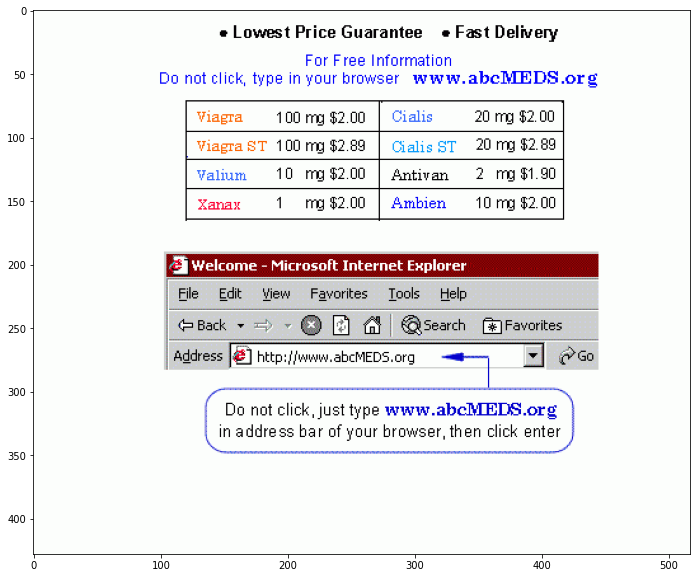

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
img_samp = cv2.imread(img_path)
plt.imshow(img_samp);

In [ ]:
prnt_out(x_img)

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Our network is 100.00% sure this is PNEUMONIA


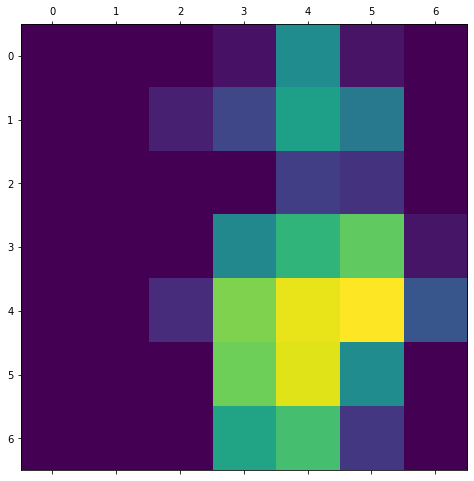

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
heatmap = xray_CAM(x_img, blck, 1)
plt.matshow(heatmap)
plt.show()

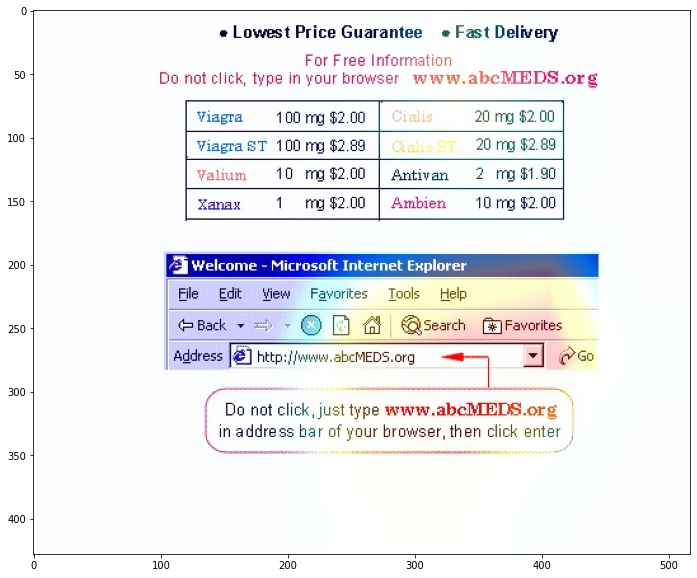

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
show_on_xray(img_path, heatmap)

Another Case of Pneumonia

### NORMAL

In [ ]:
img_path_n = '/content/drive/My Drive/image_dataset/test/class1/test_ham_50.JPG'
x_img_n = proc_img(img_path_n)
prnt_out(x_img_n)

Our network is 99.82% sure this is NORMAL


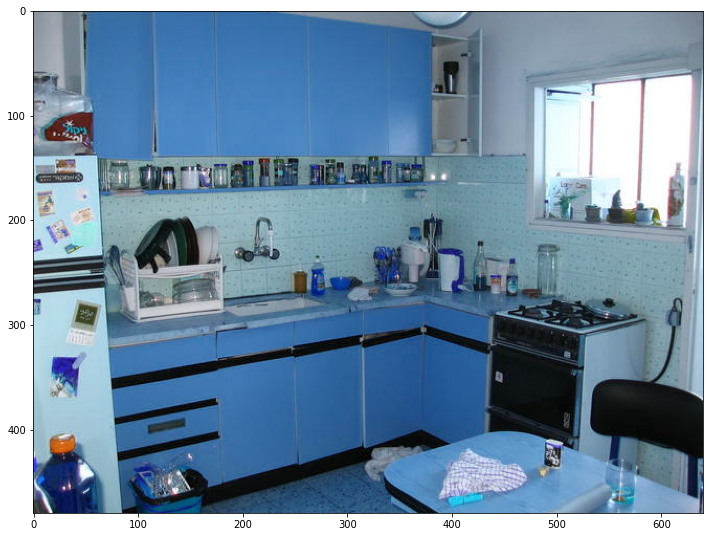

In [ ]:
img_samp_n = cv2.imread(img_path_n)
plt.imshow(img_samp_n);

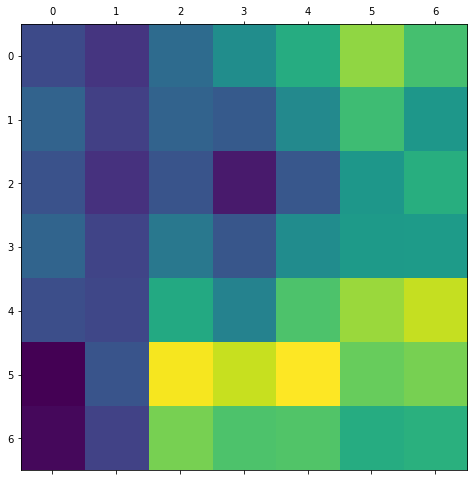

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
heatmap_n = xray_CAM(x_img_n, blck, 0)
plt.matshow(heatmap_n)
plt.show()

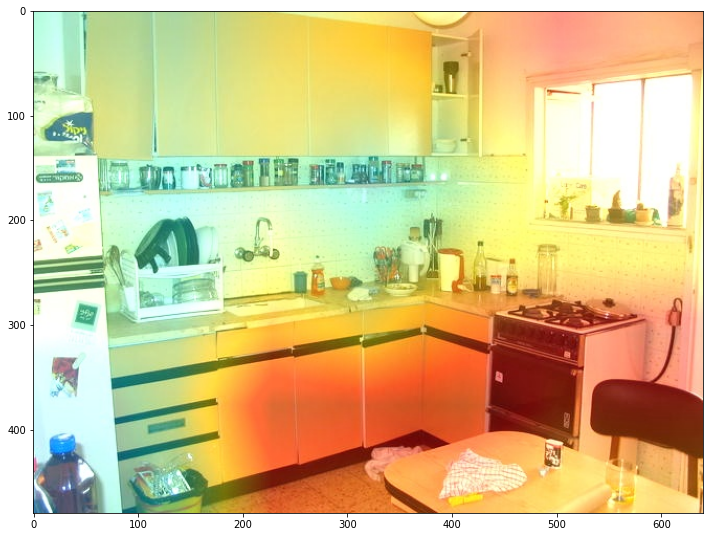

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
show_on_xray(img_path_n, heatmap_n)

# Lime: explaining image prediction

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=78a8ba48d23d2d615b281321c3aa2f9f74d72ca6c3132e883644aba7a9e04293
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries

In [ ]:
# img_path ='./chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'
# img_path = './chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg'
img_path = '/content/drive/My Drive/image_dataset/test/class2/test_spam_758.JPG'

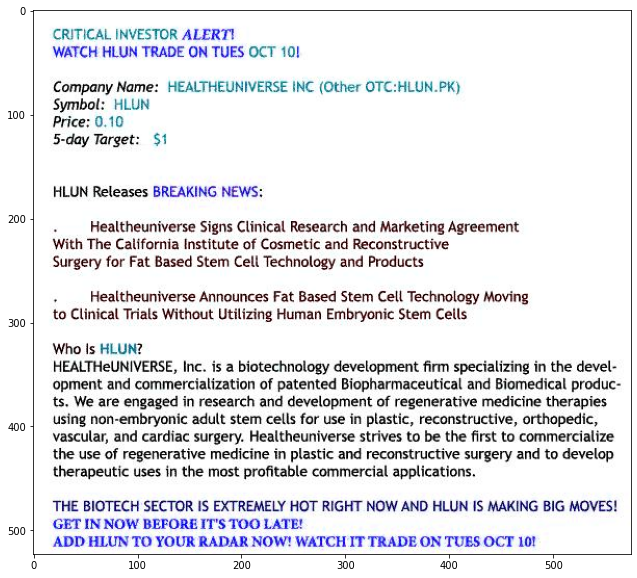

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)
img_samp_n = cv2.imread(img_path)
plt.imshow(img_samp_n);

In [ ]:
p_img = proc_img(img_path)
p_img = p_img.astype("double")
prnt_out(p_img)

Our network is 100.00% sure this is PNEUMONIA


In [ ]:
explainer = lime_image.LimeImageExplainer()

**explain_instance**(image, classifier_fn,  top_labels=5, hide_color=None,  num_samples=1000, distance_metric='cosine')



* **top_labels** – if not None, ignore labels and produce explanations for the K labels with highest prediction probabilities, where K is this parameter.
* **num_features** – maximum number of features present in explanation
* **num_samples** – size of the neighborhood to learn the linear model
* **distance_metric** – the distance metric to use for weights.



In [ ]:
explanation = explainer.explain_instance(p_img[0], model.predict,
                                         top_labels=2, hide_color=0,
                                         num_samples=1000,
                                         distance_metric='cosine')

  0%|          | 0/1000 [00:00<?, ?it/s]

**get_image_and_mask**(label, positive_only=True, hide_rest=False, num_features=5, min_weight=0.0)

* **label** – label to explain
* **positive_only** – if True, only take superpixels that contribute to the prediction of the label. Otherwise, use the top num_features superpixels, which can be positive or negative towards the label
* **hide_rest** – if True, make the non-explanation part of the return image gray
* **num_features** – number of superpixels to include in explanation



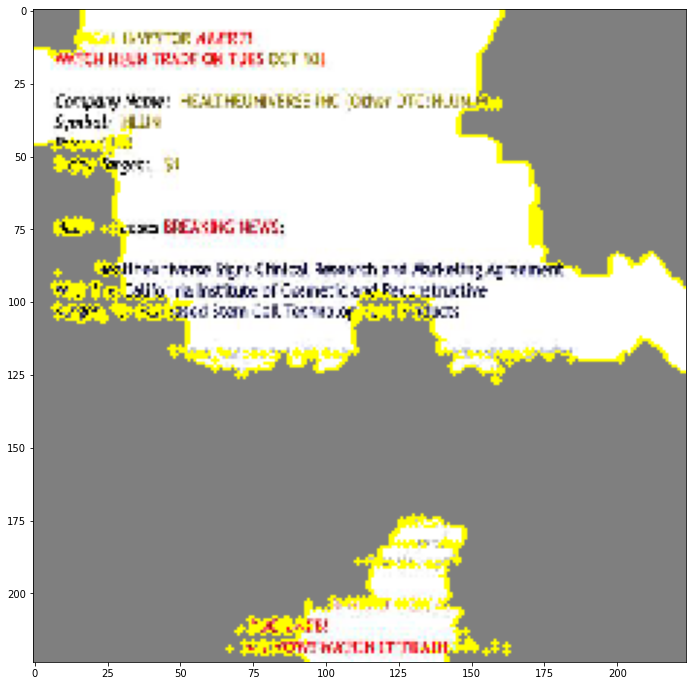

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True,
                                            num_features=15, hide_rest=True,
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.imshow(mark_boundaries(tempp, mask));

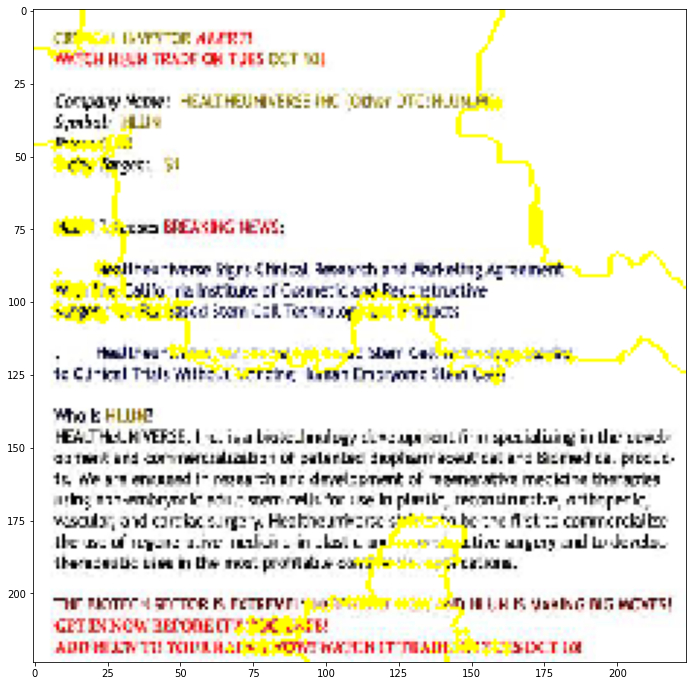

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True,
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)

tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));

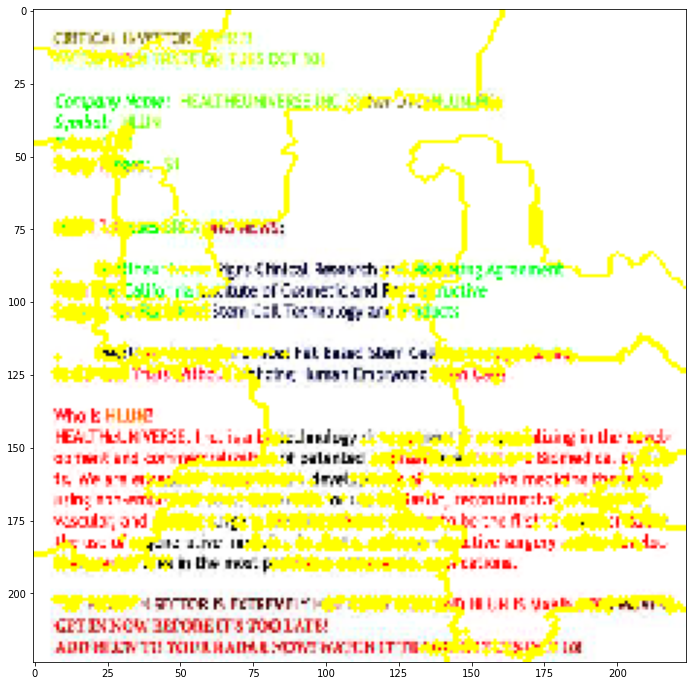

In [ ]:
temp, mask = explanation.get_image_and_mask(label=1, positive_only=False,
                                            num_features=15, hide_rest=False,
                                            min_weight=0.0000004)
tempp = np.interp(temp, (temp.min(), temp.max()), (0, +1))
plt.imshow(mark_boundaries(tempp, mask));

# References:


1. Dataset: https://www.kaggle.com/paultimothymooney/detecting-pneumonia-in-x-ray-images
2. MobileNet: https://arxiv.org/abs/1704.04861
3. Grad-CAM: https://arxiv.org/abs/1610.02391
4. Francois Chollet - Deep Learning with Python (2017, Manning Publications), Chapter 5
5. https://medium.com/@mohamedchetoui/grad-cam-gradient-weighted-class-activation-mapping-ffd72742243a
6. http://www.hackevolve.com/where-cnn-is-looking-grad-cam/
7. Lime library: https://github.com/marcotcr/lime
8. Model-Agnostic Interpretability of Machine Learning https://arxiv.org/abs/1606.05386
9. "Why Should I Trust You?": Explaining the Predictions of Any Classifier https://arxiv.org/abs/1602.04938
10. https://towardsdatascience.com/understanding-how-lime-explains-predictions-d404e5d1829c
